In [1]:
import numpy as np
import netCDF4 as nc
import pyfesom2 as pf
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cmocean

In [89]:

# %%bash 
# exps='tran20-32k-sed10  tran20-32k-sed20  tran20-32k-sed30  tran20-32k-new04'

# for i in $exps;
# do 
#     echo $i
#     datapath=/home/a/a270075/ba0989/awiesm2.5/experiments-2/${i}/outdata/pism/
#     rm -f ${i}_ts.nc 
#     cdo mergetime ${datapath}/${i}_pismr_ts_*.nc   ${i}_ts.nc 
# done 
    

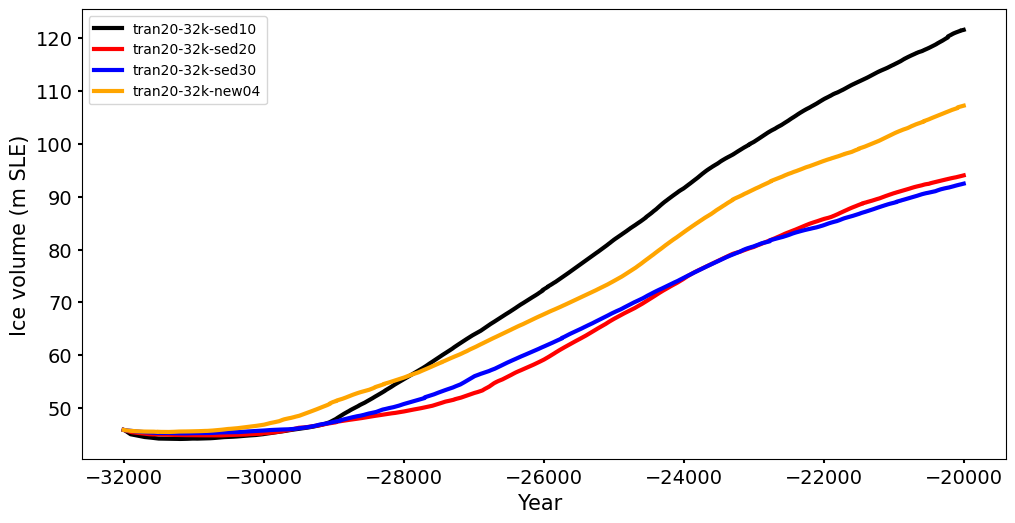

In [97]:
exps = ['tran20-32k-sed10',
        'tran20-32k-sed20',
        'tran20-32k-sed30',
        'tran20-32k-new04',
       ]

datas = [ i+'_ts.nc'  for i in exps[:] ]

datas

################# figure 
fig = plt.figure(figsize=(12,5))
fig.subplots_adjust(left=0.05,right=0.82, top=0.95, bottom=0.05, hspace=0.1,wspace=0.05)
ax = fig.add_subplot(1,1,1) 

colors = ['black', 'red', 'blue', 'orange']

for i in  range(0,len(exps)):
    with nc.Dataset(datas[i], 'r') as ff:
        sealevel = ff.variables['sea_level_rise_potential'][:]
        modelyear = ff.variables['time'][:]/365./3600./24. - 106000 - 32000

    ax.plot(modelyear, sealevel, linewidth=3, ls='-', color=colors[i], label=exps[i])
    ax.legend()    
    # ax.set_xlim(38, 13)
    # ax.set_ylim(460, 520)
    ax.set_xlabel("Year ", fontsize=15)
    ax.set_ylabel("Ice volume (m SLE)", fontsize=15)
    ax.tick_params(axis='y', **dict(size=3, width=1.5, labelsize=14))
    ax.tick_params(axis='x', **dict(size=3, width=1.5, labelsize=14))

plt.savefig('plot_ivol_total.png',bbox_inches='tight',)
# plt.show()
# plt.close()

In [92]:
# %%bash 
# expids='tran20-32k-sed10  tran20-32k-sed20  tran20-32k-sed30 '
# expids=' tran20-32k-new04'
# for i in $expids;
# do 
#     echo $i
#     datapath=/home/a/a270075/ba0989/awiesm2.5/experiments-2/${i}/restart/pism/
#     cdo -select,name=thk   ${datapath}/${i}_pismr_restart_*.nc   ${i}_thk.nc 
# done 

In [93]:
########## calculate seperately and write to a file


exps = ['tran20-32k-sed10',
        'tran20-32k-sed20',
        'tran20-32k-sed30',
        'tran20-32k-new04',
       ]

datas = [ i+'_thk.nc'  for i in exps[:] ]
datas

fmask = '/home/a/a270075/ba0989/pool/pism/grids/mask_pism.nc'


### define 
ocean_area = 3.625e14  #m^2
resolution = 20000  #m
rhoice = 910 #kg/m^3
rhosea = 1028 #kg/m^3
rr = rhoice/rhosea /ocean_area


########################################
years = np.arange(-32000,0+1,100)

with nc.Dataset(fmask) as ff:
    mask = ff.variables['mask'][:]

ones = np.zeros(mask.shape) + 1


for i in range(0,len(exps)):
    ### output files 
    dataset = nc.Dataset('pism_'+exps[i]+'_sep_ts.nc','w',format='NETCDF4_CLASSIC')
    dataset.createDimension('years', None)
    yy = dataset.createVariable('years', np.float64, ('years',))
    yy[:] = years[:]
    
    


    fname = datas[i]
    with nc.Dataset(fname) as ff:
        thk = ff.variables['thk'][:]
        area = np.where(thk>0.01, 1., 0.)

    ##### Greenland
    var1 = dataset.createVariable('ivol_grn', np.float64, ('years',))
    var2 = dataset.createVariable('iarea_grn', np.float64, ('years',))
    # volume  
    masknew = np.ma.masked_where(mask != 0, ones)
    aaa = masknew * thk * resolution * resolution * rr
    sle_grn = np.sum(np.sum(aaa,axis=1), axis=1)
    # area
    bbb = masknew * area * resolution * resolution
    iarea_grn = np.sum(np.sum(bbb,axis=1), axis=1)

    var1[:] = sle_grn[:]
    var2[:] = iarea_grn[:]
    
    
    ### North America
    var1 = dataset.createVariable('ivol_na', np.float64, ('years',))
    var2 = dataset.createVariable('iarea_na', np.float64, ('years',))
    
    condition = (mask != 1 ) & ( mask !=  2)  & ( mask !=  3)  & ( mask !=  4) & ( mask !=  5)
    masknew = np.ma.masked_where( condition , ones)
    aaa = masknew * thk * resolution * resolution * rr
    sle_na = np.sum(np.sum(aaa,axis=1), axis=1)
    # area
    bbb = masknew * area * resolution * resolution
    iarea_na = np.sum(np.sum(bbb,axis=1), axis=1)

    var1[:] = sle_na[:]
    var2[:] = iarea_na[:]
    
    # print("The index:", np.where((sle_na>83) & (sle_na<86.5)))


    ## Euasia
    var1 = dataset.createVariable('ivol_eu', np.float64, ('years',))
    var2 = dataset.createVariable('iarea_eu', np.float64, ('years',))
    
    condition = (mask != 16 ) & (mask != 17 ) &(mask != 18 ) &(mask != 28 ) &(mask != 29 ) &(mask != 46 )
    masknew = np.ma.masked_where( condition , ones)
    aaa = masknew * thk * resolution * resolution * rr
    sle_eu = np.sum(np.sum(aaa,axis=1), axis=1)
    # area
    bbb = masknew * area * resolution * resolution
    iarea_eu = np.sum(np.sum(bbb,axis=1), axis=1)

    var1[:] = sle_eu[:]
    var2[:] = iarea_eu[:]

    dataset.close()



['pism_tran20-32k-sed10_sep_ts.nc', 'pism_tran20-32k-sed20_sep_ts.nc', 'pism_tran20-32k-sed30_sep_ts.nc', 'pism_tran20-32k-new04_sep_ts.nc']


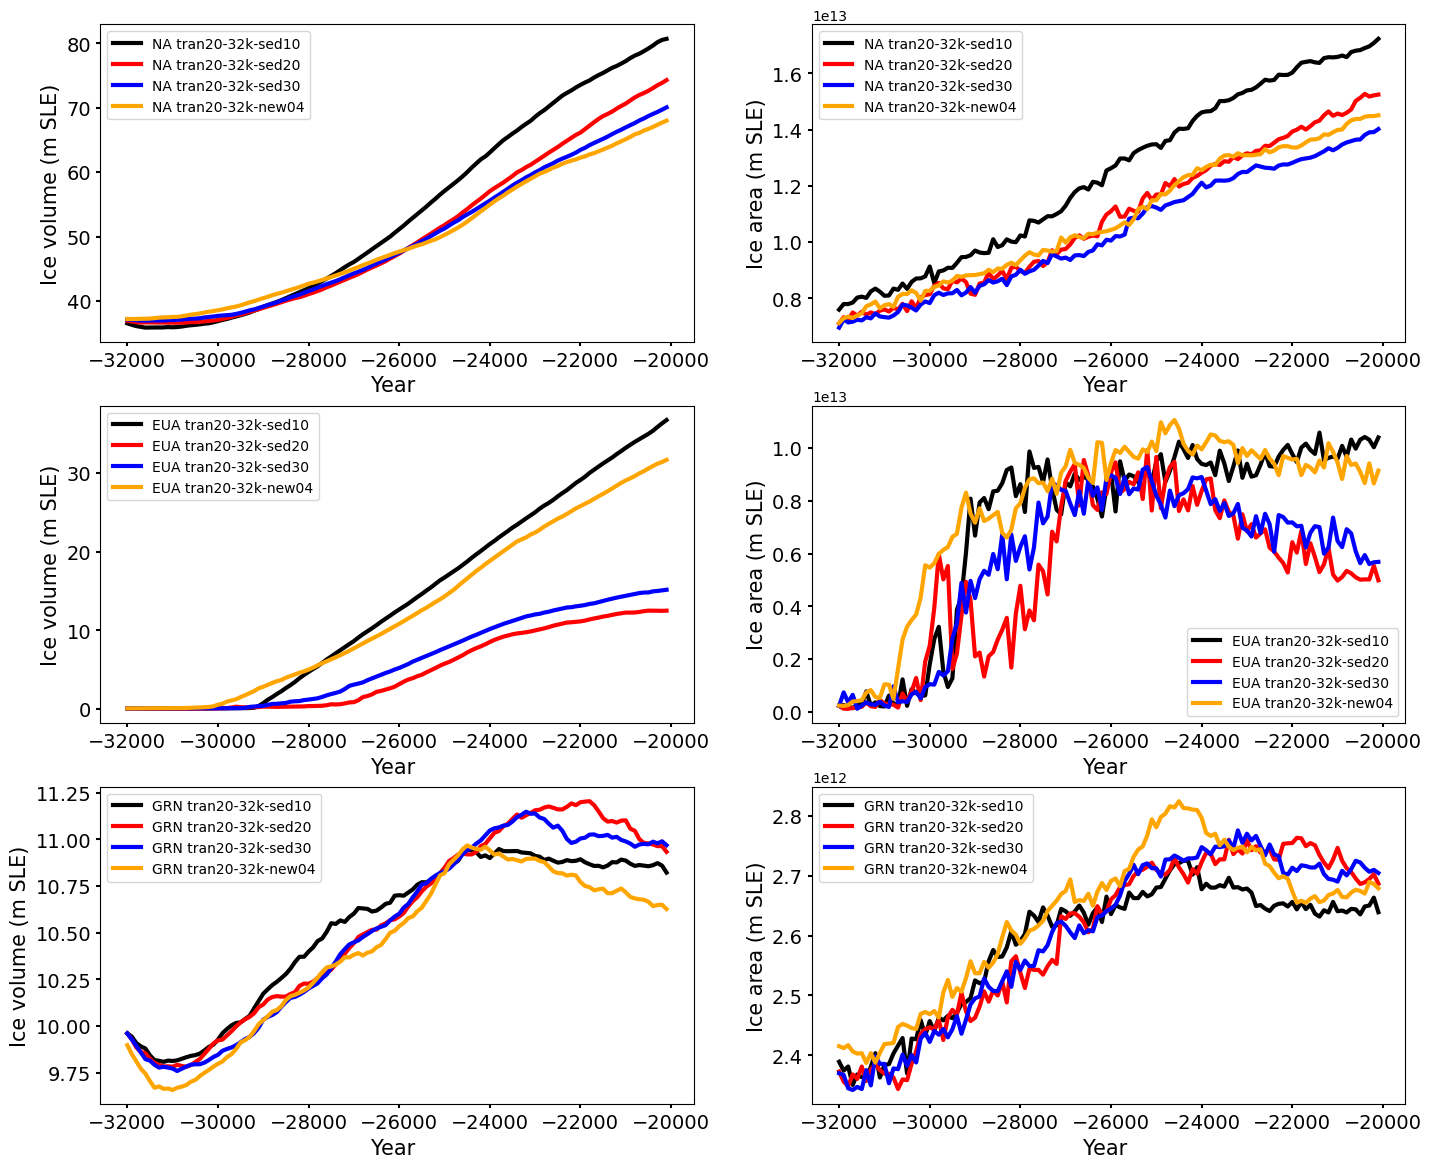

In [95]:
exps = ['tran20-32k-sed10',
        'tran20-32k-sed20',
        'tran20-32k-sed30',
        'tran20-32k-new04',
       ]

datas = ['pism_'+i+'_sep_ts.nc'  for i in exps[:] ]
print(datas) 

fig, axs = plt.subplots(3,2, figsize=(15,12) )
fig.subplots_adjust(left=0.08,right=0.95, top=0.95, bottom=0.05)
colors = ['black', 'red', 'blue', 'orange']

for i in range(0,len(exps)):
    with nc.Dataset(datas[i], 'r') as ff:
        years = ff.variables['years'][:]
        sle_na = ff.variables['ivol_na'][:]
        iarea_na = ff.variables['iarea_na'][:]
        
        sle_eu = ff.variables['ivol_eu'][:]
        iarea_eu = ff.variables['iarea_eu'][:]
        
        sle_grn = ff.variables['ivol_grn'][:]
        iarea_grn = ff.variables['iarea_grn'][:]
        
    #############   ivol  
    axs[0,0].plot( years[0:len(sle_na)], sle_na[:], linewidth=3, ls='-', label='NA '+exps[i], color=colors[i])
    #axs[0].set_xlim(-38000, -15000)
    # axs[0,0].set_ylim(0, 40)
    axs[0,0].set_ylabel("ivol SLE (m) ")
    axs[0,0].legend() #loc=(1.05,0.1))
    
    axs[0,0].set_xlabel("Year ", fontsize=15)
    axs[0,0].set_ylabel("Ice volume (m SLE)", fontsize=15)
    axs[0,0].tick_params(axis='y', **dict(size=3, width=1.5, labelsize=14))
    axs[0,0].tick_params(axis='x', **dict(size=3, width=1.5, labelsize=14))

    #############
    axs[1,0].plot( years[0:len(sle_eu)], sle_eu[:], linewidth=3, ls='-', label='EUA '+exps[i], color=colors[i])
    #axs[0].set_xlim(-38000, -15000)
    # axs[1,0].set_ylim(0, 40)
    axs[1,0].set_ylabel("ivol SLE (m) ")
    axs[1,0].legend() #loc=(1.05,0.1))
    
    axs[1,0].set_xlabel("Year ", fontsize=15)
    axs[1,0].set_ylabel("Ice volume (m SLE)", fontsize=15)
    axs[1,0].tick_params(axis='y', **dict(size=3, width=1.5, labelsize=14))
    axs[1,0].tick_params(axis='x', **dict(size=3, width=1.5, labelsize=14))

    #############
    axs[2,0].plot( years[0:len(sle_grn)], sle_grn[:], linewidth=3, ls='-', label='GRN '+exps[i], color=colors[i])
    #axs[0].set_xlim(-38000, -15000)
    # axs[1,0].set_ylim(0, 40)
    axs[2,0].set_ylabel("ivol SLE (m) ")
    axs[2,0].legend() #loc=(1.05,0.1))
    
    axs[2,0].set_xlabel("Year ", fontsize=15)
    axs[2,0].set_ylabel("Ice volume (m SLE)", fontsize=15)
    axs[2,0].tick_params(axis='y', **dict(size=3, width=1.5, labelsize=14))
    axs[2,0].tick_params(axis='x', **dict(size=3, width=1.5, labelsize=14))

    

    #############   iarea  
    axs[0,1].plot( years[0:len(iarea_na)], iarea_na[:], linewidth=3, ls='-', label='NA '+exps[i], color=colors[i])
    #axs[0].set_xlim(-38000, -15000)
    # axs[0,0].set_ylim(0, 40)
    axs[0,1].set_ylabel("ivol SLE (m) ")
    axs[0,1].legend() #loc=(1.05,0.1))
    
    axs[0,1].set_xlabel("Year ", fontsize=15)
    axs[0,1].set_ylabel("Ice area (m SLE)", fontsize=15)
    axs[0,1].tick_params(axis='y', **dict(size=3, width=1.5, labelsize=14))
    axs[0,1].tick_params(axis='x', **dict(size=3, width=1.5, labelsize=14))

    #############
    axs[1,1].plot( years[0:len(iarea_eu)], iarea_eu[:], linewidth=3, ls='-', label='EUA '+exps[i], color=colors[i])
    #axs[0].set_xlim(-38000, -15000)
    # axs[1,0].set_ylim(0, 40)
    axs[1,1].set_ylabel("ivol SLE (m) ")
    axs[1,1].legend() #loc=(1.05,0.1))
    
    axs[1,1].set_xlabel("Year ", fontsize=15)
    axs[1,1].set_ylabel("Ice area (m SLE)", fontsize=15)
    axs[1,1].tick_params(axis='y', **dict(size=3, width=1.5, labelsize=14))
    axs[1,1].tick_params(axis='x', **dict(size=3, width=1.5, labelsize=14))

    #############
    axs[2,1].plot( years[0:len(iarea_grn)], iarea_grn[:], linewidth=3, ls='-', label='GRN '+exps[i], color=colors[i])
    #axs[0].set_xlim(-38000, -15000)
    # axs[1,0].set_ylim(0, 40)
    axs[2,1].set_ylabel("ivol SLE (m) ")
    axs[2,1].legend() #loc=(1.05,0.1))
    
    axs[2,1].set_xlabel("Year ", fontsize=15)
    axs[2,1].set_ylabel("Ice area (m SLE)", fontsize=15)
    axs[2,1].tick_params(axis='y', **dict(size=3, width=1.5, labelsize=14))
    axs[2,1].tick_params(axis='x', **dict(size=3, width=1.5, labelsize=14))

plt.savefig('plot_ivol_ts_sep.png',bbox_inches='tight',)
# plt.show()
# plt.close()